In [46]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon
from tqdm import tqdm
import descartes
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import repeat
import time
%matplotlib inline
%config InlineBackend.figure_format='retina'

Get 2020 block group shapes from IPUMS dataset

In [4]:
SHAPE_FILEPATH = "data/nhgis0009_shape"

def load_blocks(state, fips):
    """
    Loads a state's 2020 census blocks from IPUMS dataset.
    
    Parameters
    ----------
    state : string
        US state acronym (i.e 'CA') for requested block data.
    fips : string
        zero-padded state FIPS code for requested block data.
    
    Returns
    -------
    geopandas.GeoDataFrame
        block data of given state.
    """
    begin = time.time()
    blocks = gpd.read_file(f'{SHAPE_FILEPATH}/{state}_blck_grp_2020.shp')
    print(f'{state} blocks loaded. Time: {np.round(time.time() - begin, 2)}s')
    return blocks

ca_blocks = load_blocks('CA', '060')
# ga_blocks = load_blocks('GA', '130')
# il_blocks = load_blocks('IL', '170')
# md_blocks = load_blocks('MD', '240')
# mi_blocks = load_blocks('MI', '260')
# ny_blocks = load_blocks('NY', '360')
# pa_blocks = load_blocks('PA', '420')

CA blocks loaded. Time: 1.91s


In [5]:
ca_blocks.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G06000104001001,06,001,400100,1,060014001001,Block Group 1,G5030,S,5737663.0,0.0,+37.8698780,-122.2336208,11305.731937,5.737660e+06,"POLYGON ((-2255658.646 354418.079, -2255703.36..."
1,G06000104001002,06,001,400100,2,060014001002,Block Group 2,G5030,S,1208194.0,0.0,+37.8571050,-122.2236217,8258.773645,1.208193e+06,"POLYGON ((-2255658.646 354418.079, -2255765.06..."
2,G06000104002001,06,001,400200,1,060014002001,Block Group 1,G5030,S,288070.0,0.0,+37.8497451,-122.2488478,2971.010308,2.880696e+05,"POLYGON ((-2258184.246 353217.527, -2258186.81..."
3,G06000104002002,06,001,400200,2,060014002002,Block Group 2,G5030,S,298490.0,0.0,+37.8465865,-122.2503095,3162.343955,2.984887e+05,"POLYGON ((-2258439.130 352894.146, -2258619.65..."
4,G06000104003001,06,001,400300,1,060014003001,Block Group 1,G5030,S,265695.0,0.0,+37.8439848,-122.2486668,2553.074982,2.656948e+05,"POLYGON ((-2258662.984 352641.307, -2258755.16..."


In [6]:
ca_blocks.crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
def adjust_data(blocks, target_crs, counties):
    """
    Removes irrelevant columns and puts data in redlining maps' CRS.
    
    Parameters
    ----------
    blocks : geopandas.GeoDataFrame
        (raw) block data for a given state.
    target_crs : pyproj.crs.crs.CRS
        Coordinate Reference System (CRS) to re-project data onto.
    counties : list
        list of county FIPS codes for relevant cities for analysis.
    
    Returns
    -------
    geopandas.GeoDataFrame
        cleaned block data for the state.
    """
    blocks = blocks.loc[blocks.COUNTYFP.isin(counties)]
    blocks = blocks.to_crs(target_crs)
    return blocks.filter(['COUNTYFP', 'GEOID', 'geometry'])

Now, start working on the HOLC map. The dataset gives this to us in MultiPolygon form, which is hard to merge with Polygons, so we "polygonize" the map by merging all polygons within a multipolygon into a single polygon.

In [24]:
# function to polygonize a geometry list
polygonize = lambda s: [shapely.ops.unary_union(x) if type(x) == shapely.geometry.multipolygon.MultiPolygon 
                           else x 
                           for x in s.values]

oakland_rl_map = gpd.read_file("data/redlining-maps/CAOakland1937.geojson")
oakland_rl_map['polygonized'] = polygonize(oakland_rl_map.geometry)

# sd_rl_map = gpd.read_file("data/redlining-maps/CASanDiego1938.geojson")
# sd_rl_map['polygonized'] = polygonize(sd_rl_map.geometry)

# atlanta_rl_map = gpd.read_file("data/redlining-maps/GAAtlanta1938.geojson")
# atlanta_rl_map['polygonized'] = polygonize(atlanta_rl_map.geometry)

# chicago_rl_map = gpd.read_file("data/redlining-maps/ILChicago1940.geojson")
# chicago_rl_map['polygonized'] = polygonize(chicago_rl_map.geometry)

# baltimore_rl_map = gpd.read_file("data/redlining-maps/MDBaltimore1937.geojson")
# baltimore_rl_map['polygonized'] = polygonize(baltimore_rl_map.geometry)

# detroit_rl_map = gpd.read_file("data/redlining-maps/MIDetroit1939.geojson")
# detroit_rl_map['polygonized'] = polygonize(detroit_rl_map.geometry)

# bronx_rl_map = gpd.read_file("data/redlining-maps/NYBronx1938.geojson")
# bronx_rl_map['polygonized'] = polygonize(bronx_rl_map.geometry)

# brooklyn_rl_map = gpd.read_file("data/redlining-maps/NYBrooklyn1938.geojson")
# brooklyn_rl_map['polygonized'] = polygonize(brooklyn_rl_map.geometry)

# manhattan_rl_map = gpd.read_file("data/redlining-maps/NYManhattan1937.geojson")
# manhattan_rl_map['polygonized'] = polygonize(manhattan_rl_map.geometry)

# queens_rl_map = gpd.read_file("data/redlining-maps/NYQueens1938.geojson")
# queens_rl_map['polygonized'] = polygonize(queens_rl_map.geometry)

# philly_rl_map = gpd.read_file("data/redlining-maps/PAPhiladelphia1937.geojson")
# philly_rl_map['polygonized'] = polygonize(philly_rl_map.geometry)

In [25]:
ca_filtered = adjust_data(ca_blocks, oakland_rl_map.crs, ['001', '073'])
# ga_filtered = adjust_data(ga_blocks, atlanta_rl_map.crs, ['121', '089'])
# il_filtered = adjust_data(il_blocks, chicago_rl_map.crs, ['031'])
# md_filtered = adjust_data(md_blocks, baltimore_rl_map.crs, ['510'])
# mi_filtered = adjust_data(mi_blocks, detroit_rl_map.crs, ['163'])
# ny_filtered = adjust_data(ny_blocks, bronx_rl_map.crs, ['005', '047', '061', '081'])
# pa_filtered = adjust_data(pa_blocks, philly_rl_map.crs, ['101'])

In [26]:
oakland_rl_map

,name,holc_id,holc_grade,area_description_data,geometry,polygonized
0,None,A,A,{'': ''},"MULTIPOLYGON (((-122.20252 37.81099, -122.2023...","POLYGON ((-122.202522 37.810986, -122.202308 3..."
1,None,A1,A,"{'1': 'Berkeley Green A-1', '2': 'Characterize...","MULTIPOLYGON (((-122.26319 37.90040, -122.2618...","POLYGON ((-122.263194 37.900395, -122.261827 3..."
2,None,A10,A,"{'1': 'Oakland, California Low Green A-10', '2...","MULTIPOLYGON (((-122.23403 37.80671, -122.2343...","POLYGON ((-122.23403 37.80671, -122.234358 37...."
3,None,A11,A,"{'1': 'Oakland, California Green A-11', '2': '...","MULTIPOLYGON (((-122.20252 37.81099, -122.2033...","POLYGON ((-122.202522 37.810986, -122.203372 3..."
4,None,A2,A,"{'1': 'Berkeley, California Green A-2', '2': '...","MULTIPOLYGON (((-122.27847 37.89710, -122.2785...","POLYGON ((-122.278471 37.897102, -122.278515 3..."
...,...,...,...,...,...,...
114,None,D5,D,"{'1': 'Oakland, California Red D-5', '2': 'Lev...","MULTIPOLYGON (((-122.26074 37.84620, -122.2620...","POLYGON ((-122.260739 37.846202, -122.262046 3..."
115,None,D6,D,"{'1': 'Emeryville, California Red D-6', '2': '...","MULTIPOLYGON (((-122.28262 37.83666, -122.2805...","POLYGON ((-122.282619 37.836662, -122.280516 3..."
116,None,D7,D,"{'1': 'Oakland, California Red D-7', '2': 'Lev...","MULTIPOLYGON (((-122.27342 37.81527, -122.2738...","(POLYGON ((-122.282619 37.836662, -122.284152 ..."
117,None,D8,D,"{'1': 'Oakland, California Red D-8', '2': 'Lev...","MULTIPOLYGON (((-122.27957 37.82746, -122.2743...","POLYGON ((-122.279575 37.827465, -122.274356 3..."


Now that we have the Block groups and the HOLC maps filtered and cleaned, and in the same CRS (so the projection is the same), we can start to look at overlaps to build the crosswalk.

In [29]:
def area_overlap(a, b):
    """
    Determines what % of a polygon overlaps with another.
    
    Parameters
    ----------
    a : shapely.geometry.Polygon
        first polygon to check overlap of ("overlaid" on b).
    b : shapely.geometry.Polygon
        polygon to check a against.
    
    Returns
    -------
    float
        % of polygon A which lies within polygon B.
    """
    try:
        return a.intersection(b).area / a.area
    except: # case where polygon is self-wrapping or invalid, throw it out
        return 0

In [30]:
def generate_crosswalk(city_args):
    """
    Returns a crosswalk of 1940 tract_ids in each redlined district.
    
    Parameters
    ----------
    city_args : tuple
        all args needed for method:
        city_name : string
            city to analyze.
        city_fips : list
            county FIPS codes for counties within the city.
        rl_map : geopandas.GeoDataFrame
            redlining district data for the city.
        bg_map : geopandas.GeoDataFrame
            2020 block group data for the state the city is in.
    
    Returns
    -------
    pandas.DataFrame
        crosswalk between redlining districts and blocks, with the following format:
        index | holc_id_uq | block_id_2010
        ----------------------------------
        <int> | <string>   | <string>
    """
    # parse tuple
    city_name, city_fips, rl_map, bg_map = city_args
    
    # filter state blocks to just the ones in the city we're interested in
    if (len(np.unique(bg_map.COUNTYFP.values)) > len(city_fips)):
        blocks = bg_map.loc[bg_map.COUNTYFP.isin(city_fips)]
    else:
        blocks = bg_map
    rl_geometries = rl_map.polygonized.values
    
    bg_id_2020 = []
    holc_id_uq = []
    
    for i in blocks.index: # iterate through the 2010 blocks
        # for each 2010 block, see it's overlap with each holc_id
        overlaps = list(map(area_overlap, repeat(blocks.loc[i].geometry), rl_geometries))
        if sum(overlaps) > 0.5:
            # since some districts don't have an id, max_district_id is composed of the district's grade + 
            # the district's index in the rl_map
            max_district_id = f'{rl_map.loc[np.argmax(overlaps)].holc_grade}{np.argmax(overlaps)}'
            bg_id_2020.append(blocks.loc[i].GEOID)
            holc_id_uq.append(max_district_id)
    
    crosswalk = pd.DataFrame({'bg_id_2020': bg_id_2020, 'holc_id_uq': holc_id_uq})
    crosswalk.set_index('bg_id_2020', inplace=True)
    
    # summarize
    districts_with_similarity = np.round(len(crosswalk.index) / len(blocks.index),3)
    print(f"For {city_name}, {len(crosswalk.index)} / {len(blocks.index)} block groups were matched to a district.")
    return crosswalk

In [31]:
import concurrent.futures
# crosswalk_args = [('Oakland', ['001'], oakland_rl_map, ca_filtered),
#                  ('San Diego', ['073'], sd_rl_map, ca_filtered),
#                  ('Atlanta', ['121', '089'], atlanta_rl_map, ga_filtered),
#                  ('Chicago', ['031'], chicago_rl_map, il_filtered),
#                  ('Baltimore', ['510'], baltimore_rl_map, md_filtered),
#                  ('Detroit', ['163'], detroit_rl_map, mi_filtered),
#                  ('Bronx', ['005'], bronx_rl_map, ny_filtered),
#                  ('Brooklyn', ['047'], brooklyn_rl_map, ny_filtered),
#                  ('Manhattan', ['061'], manhattan_rl_map, ny_filtered),
#                  ('Queens', ['081'], queens_rl_map, ny_filtered),
#                  ('Philadelphia', ['101'], philly_rl_map, pa_filtered)]

crosswalk_args = [('Oakland', ['001'], oakland_rl_map, ca_filtered)]

with concurrent.futures.ProcessPoolExecutor() as executor:
    for city, crosswalk in zip(list(map(lambda x: x[0], crosswalk_args)), 
                               executor.map(generate_crosswalk, crosswalk_args)):
        crosswalk.to_csv(f'data/2020_outputs/{city}_bg_2020_crosswalk.csv')
        print(f'Crosswalk for {city} written.')


For Oakland, 469 / 1133 block groups were matched to a district.
Crosswalk for Oakland written.


In [32]:
oakland_crosswalk = pd.read_csv('data/2020_outputs/Oakland_bg_2020_crosswalk.csv', 
                           dtype={'block_id_uq':str})
oakland_crosswalk['bg_id_2020'] = list(map(lambda x: f'0{x}', oakland_crosswalk.bg_id_2020))
oakland_crosswalk.set_index('bg_id_2020', inplace=True)
oakland_crosswalk

,holc_id_uq
bg_id_2020,
060014002001,B14
060014002002,C59
060014003001,C59
060014003002,C59
060014003003,C59
...,...
060014326022,C84
060014326023,C84
060014327001,B48


Text(0.5, 1.0, '2020 Block Group Representation')

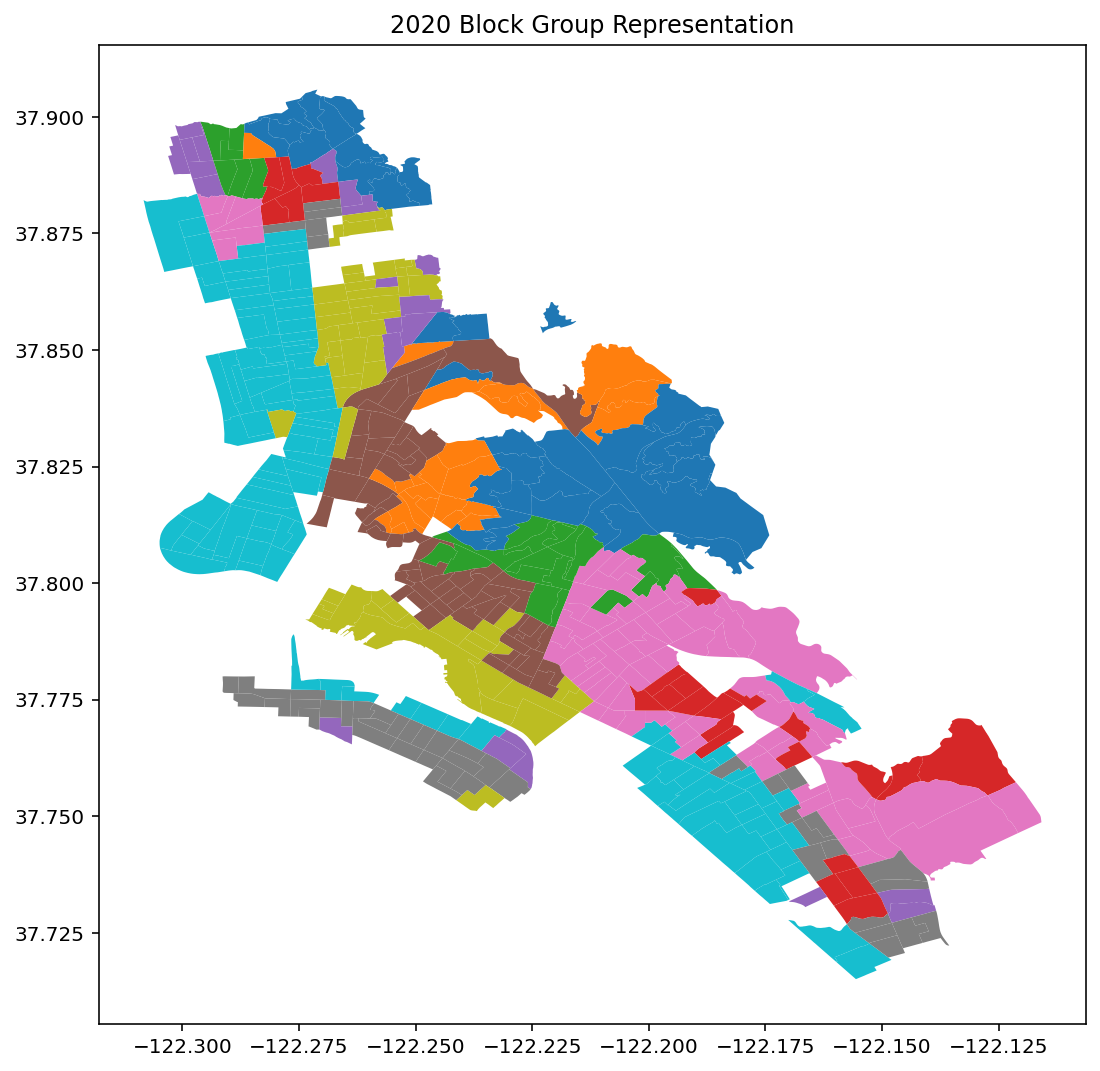

In [48]:
oak_full = ca_filtered.set_index('GEOID').join(oakland_crosswalk, how='outer').dropna()

fig, axs = plt.subplots( figsize=(16, 9))
oak_full.plot(column='holc_id_uq', ax=axs)
# oakland_rl_map.plot(column='holc_id', ax=axs)

# axs[0].set_title("1937 HOLC Redlining Map")
axs.set_title("2020 Block Group Representation")

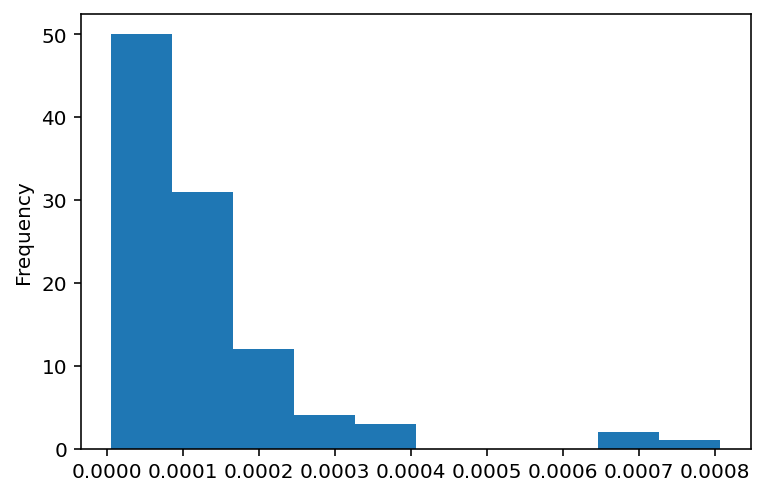

In [54]:
oak_full.dissolve(by="holc_id_uq")['geometry'].apply(lambda x: x.area).plot(kind='hist')

In [7]:
pd.read_csv("data/nhgis0010_csv/nhgis0010_ds248_2020_blck_grp.csv", usecols=["GISJOIN", 'GEOID', 'BLKGRPA', "BLOCKA"]).head()

,GISJOIN,GEOID,BLKGRPA,BLOCKA
0,G06000104001001,1500000US060014001001,1,NaN
1,G06000104001002,1500000US060014001002,2,NaN
2,G06000104002001,1500000US060014002001,1,NaN
3,G06000104002002,1500000US060014002002,2,NaN
4,G06000104003001,1500000US060014003001,1,NaN


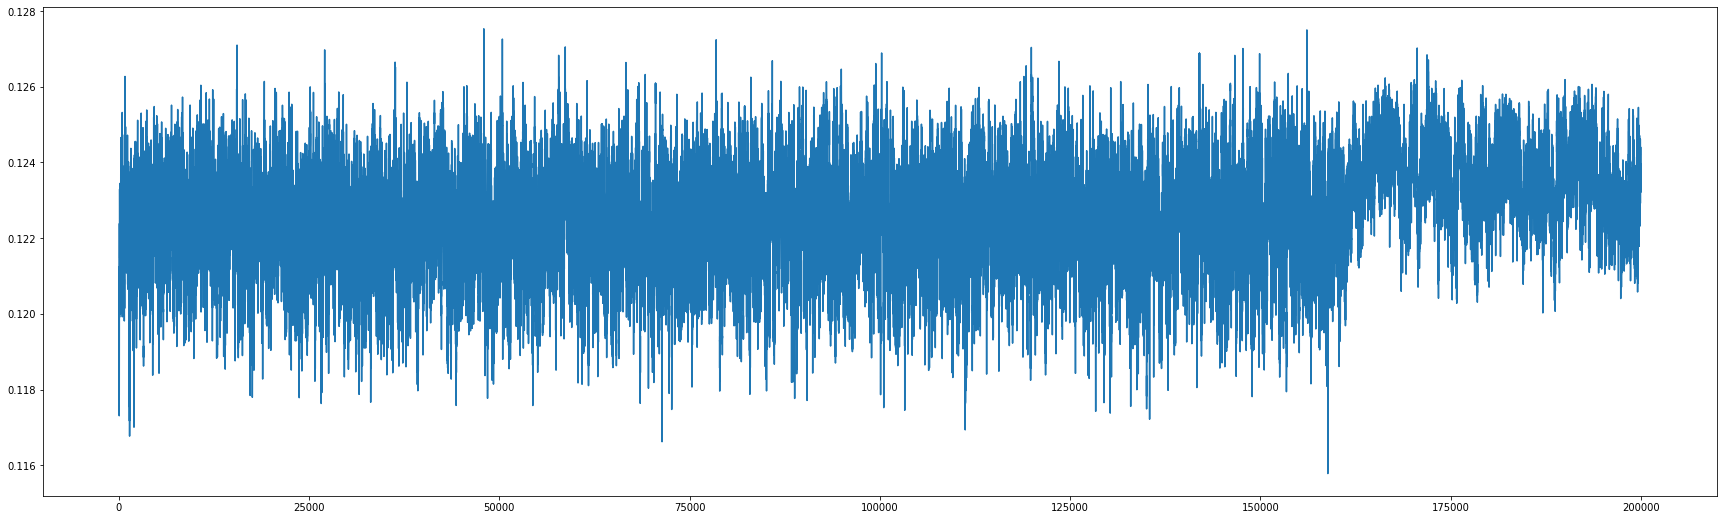

In [13]:
entropies = np.load("./results_2020/arrays/oakland_cf_1000000.npy")
plt.figure(figsize=(30, 9))
plt.plot(entropies)

In [38]:
g = oak_full.loc[oak_full['holc_id_uq'] == 'C59']['geometry'].values
g

<GeometryArray>
Length: 7, dtype: geometry

In [43]:
from shapely.ops import cascaded_union

type(cascaded_union(g))

shapely.geometry.polygon.Polygon

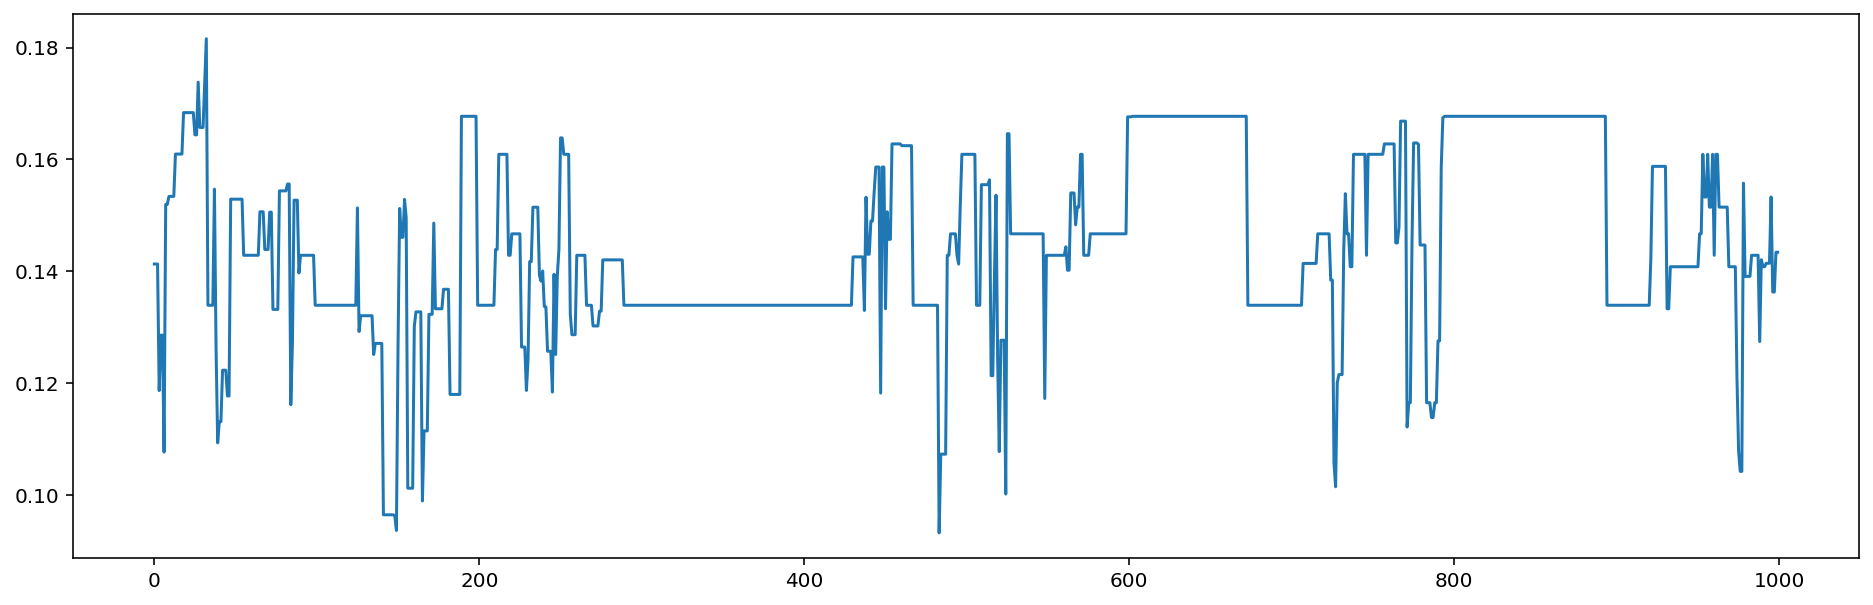

In [47]:
plt.figure(figsize=(16, 5))
plt.plot(np.load("./results_2020/polsby_popper_oakland.npy"))